In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform, randint
import joblib
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier


%matplotlib inline

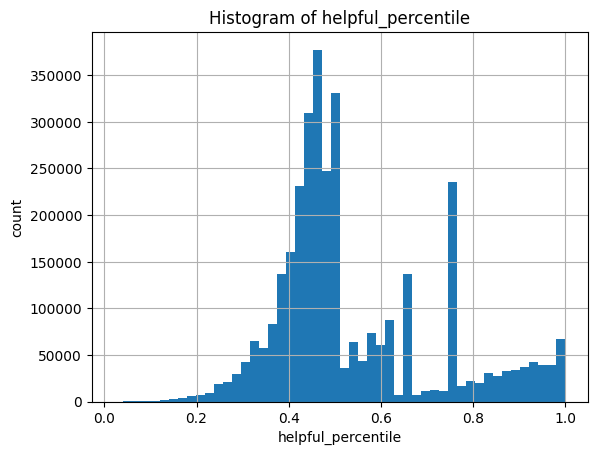

In [2]:
df = pd.read_pickle("df_processed_sentiment.pkl")
df = df.drop(columns=['asin', 'images_meta', 'categories', 'description', 'videos'])
df["helpful_percentile"] = df.groupby("parent_asin")["helpful_vote"].rank(pct=True)
df["is_helpful"] = (df["helpful_percentile"] >= 0.60).astype(int)
cond = (df['helpful_percentile'] == 1.0) & (df['helpful_vote'] < 5)
df = df.loc[~cond].reset_index(drop=True)

ax = df['helpful_percentile'].hist(bins=50)
ax.set_xlabel('helpful_percentile')
ax.set_ylabel('count')
ax.set_title('Histogram of helpful_percentile')
plt.show()


In [3]:
#Select 100000 random samples from the product categories All Beauty, AMAZON FASHION, Appliances and Health & Personal Care
#And get an 50% - 50% split of helpful and not helpful reviews 
df_sampled = pd.DataFrame()
for category in ['All Beauty', 'AMAZON FASHION', 'Appliances', 'Health & Personal Care']:
    df_category = df[df['main_category'] == category]
    df_helpful = df_category[df_category['is_helpful'] == 1].sample(n=100000, replace=True)
    df_not_helpful = df_category[df_category['is_helpful'] == 0].sample(n=100000, replace=True)
    df_sampled = pd.concat([df_sampled, df_helpful, df_not_helpful], ignore_index=True)


In [4]:
df = df_sampled.copy()

In [5]:
print("Is helpful:", len(df_sampled[df_sampled['is_helpful'] == 1]))
print("Is not helpful:", len(df_sampled[df_sampled['is_helpful'] == 0]))

Is helpful: 400000
Is not helpful: 400000


In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["is_helpful"]), df["is_helpful"], test_size=0.3)
dropping_list = ['title_data', 'text', 'helpful_vote', 'title_meta', 'average_rating', 'rating_number', 'features', 'store', 'details', 'helpful_percentile', 'timestamp']
X_train = X_train.drop(columns=dropping_list)
X_test = X_test.drop(columns=dropping_list)
X_train = X_train.drop(columns=['user_id'])
X_test = X_test.drop(columns=['user_id'])

cols = ['parent_asin','main_category', 'sentiment']

# convert to pandas string dtype for both train and test
X_train[cols] = X_train[cols].astype('category')
X_test[cols] = X_test[cols].astype('category')

# verify
X_train[cols].dtypes, X_test[cols].dtypes




(parent_asin      category
 main_category    category
 sentiment        category
 dtype: object,
 parent_asin      category
 main_category    category
 sentiment        category
 dtype: object)

In [7]:
X_train = X_train.drop(columns=['parent_asin', 'main_category', 'sentiment'])
X_test = X_test.drop(columns=['parent_asin', 'main_category', 'sentiment'])

In [15]:
def evaluate_model(y_test, y_pred, y_proba):
    """
    Plots the confusion matrix, ROC curve, and prints AUC score.

    Parameters:
    - y_test  : true labels
    - y_pred  : predicted class labels
    - y_proba : predicted probabilities for the positive class
    """

    # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    # --- ROC Curve and AUC ---
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    print(f"AUC Score: {roc_auc:.4f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0, 1])
    plt.ylim([0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()


c:\Users\Niels\anaconda3\envs\thesis\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
25 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Niels\anaconda3\envs\thesis\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Niels\anaconda3\envs\thesis\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "c:\Users\Niels\anaconda3\envs\thesis\Lib\site-packages\sklearn\base.py", line 471, in _validate_params
    validate_parameter_constraints(
  F

Confusion Matrix:
[[85050 35141]
 [61196 58613]]


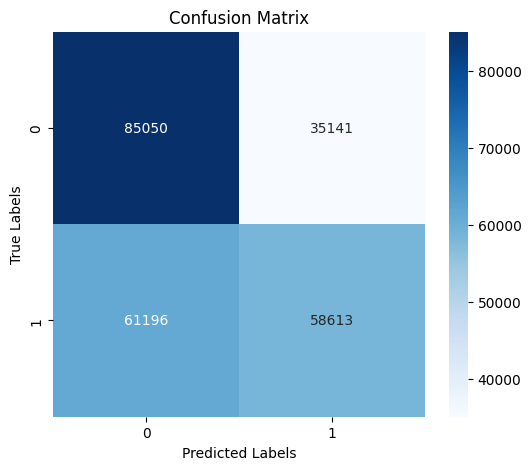

AUC Score: 0.6348


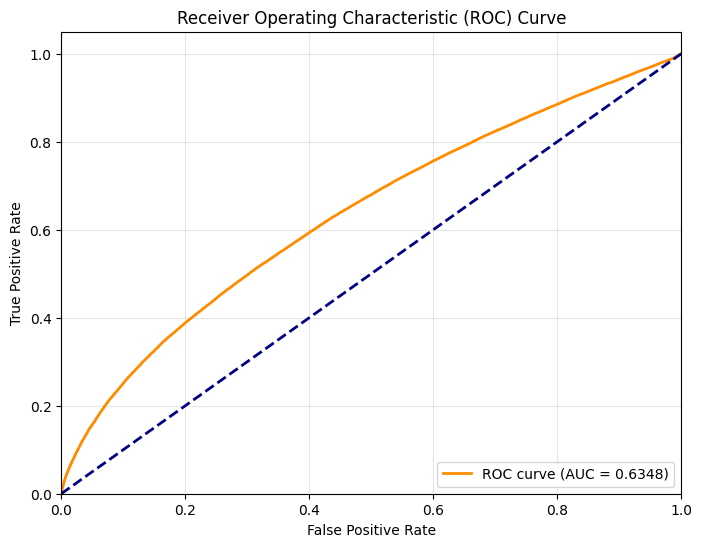

c:\Users\Niels\anaconda3\envs\thesis\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Niels\anaconda3\envs\thesis\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Niels\anaconda3\envs\thesis\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "c:\Users\Niels\anaconda3\envs\thesis\Lib\site-packages\sklearn\base.py", line 471, in _validate_params
    validate_parameter_constraints(
  F

Confusion Matrix:
[[84254 35937]
 [58914 60895]]


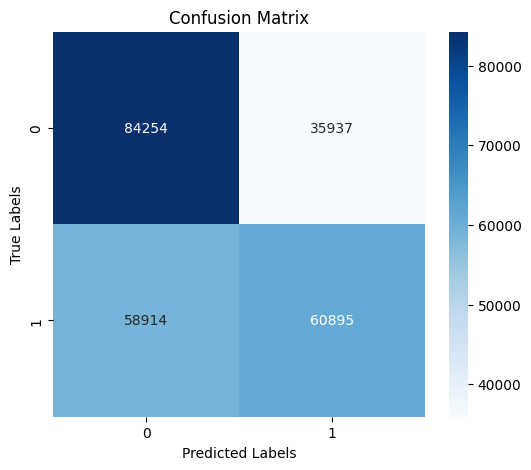

AUC Score: 0.6435


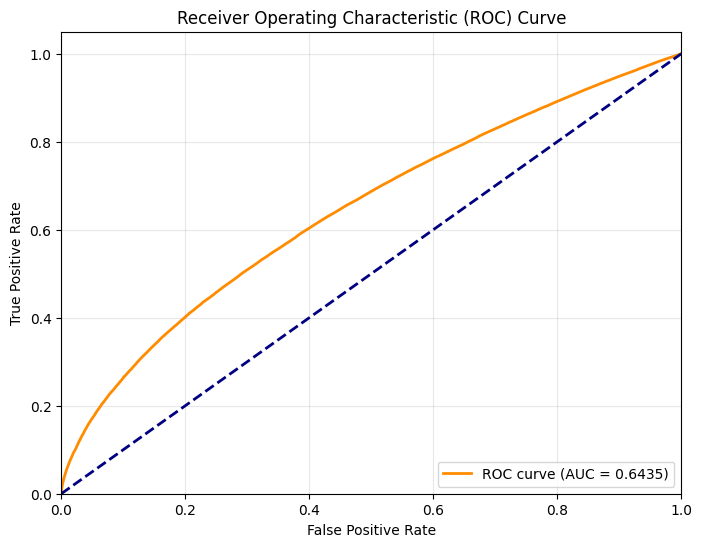

c:\Users\Niels\anaconda3\envs\thesis\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:29:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor", "verbose" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
[[84119 36072]
 [58842 60967]]


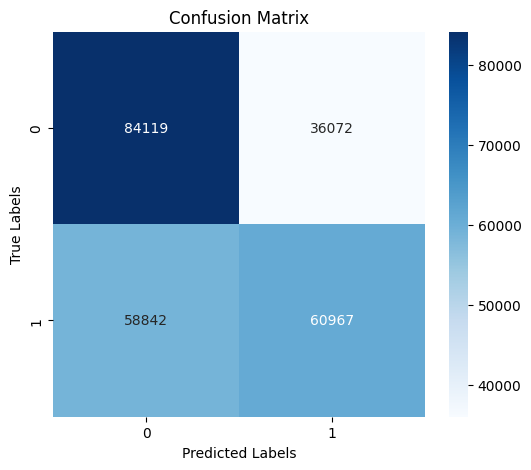

AUC Score: 0.6433


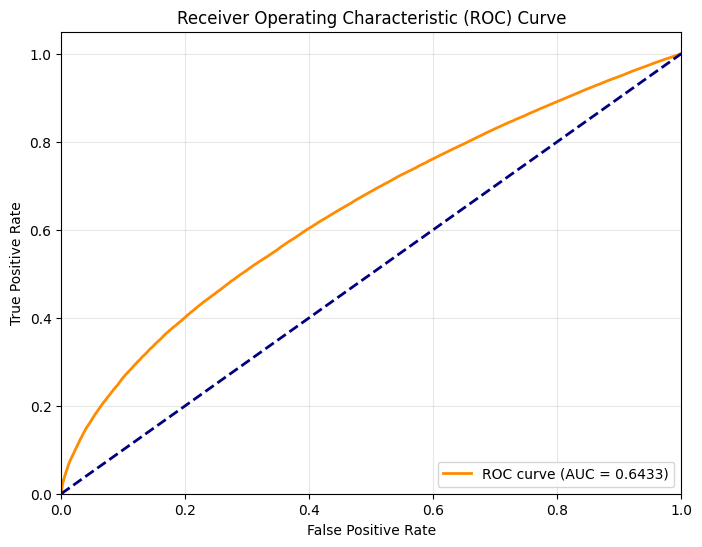

Confusion Matrix:
[[83363 36828]
 [58707 61102]]


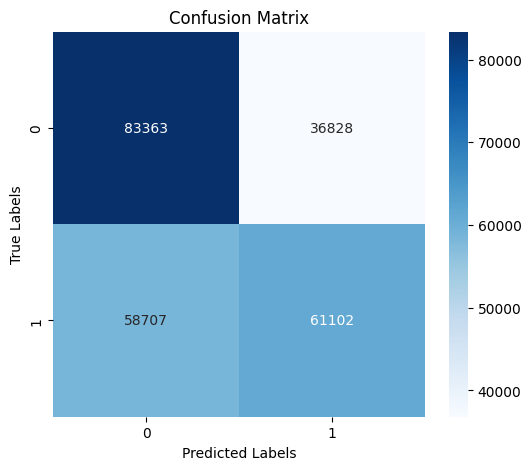

AUC Score: 0.6411


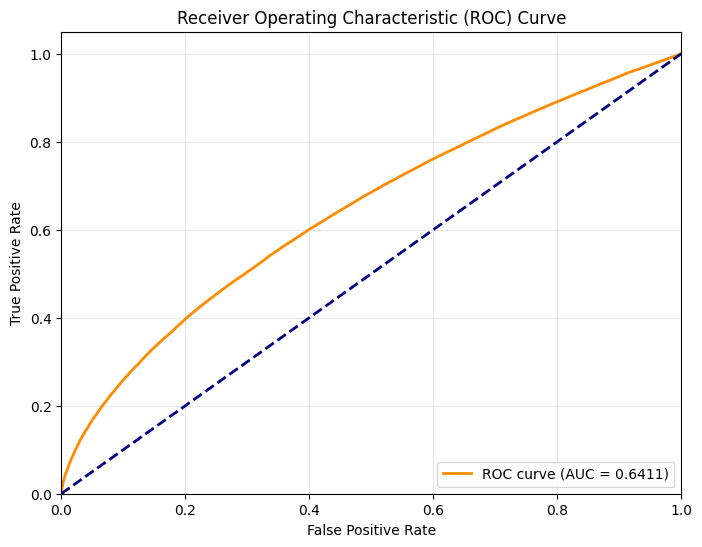

In [17]:
#Train a logistic regression, Random Forest, XGBoost and MLP with a randomsearchCV and then save the best models from each to disk using joblib and in the end print the AUC
# Logistic Regression
lr = LogisticRegression(max_iter=1000, n_jobs=-1, verbose=0)
lr_param_dist = {
    'C': [0.1, 1, 10],
    'penalty': ['l2', 'none'],
    'solver': ['lbfgs', 'saga', 'liblinear'],
    'fit_intercept': [True, False]
}
lr_search = RandomizedSearchCV(lr, lr_param_dist, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
lr_search.fit(X_train, y_train)
joblib.dump(lr_search.best_estimator_, 'best_logistic_regression_model.pkl')
y_pred = lr_search.predict(X_test)
y_proba = lr_search.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred, y_proba)
#RandomForest
rf = RandomForestClassifier(n_jobs=-1, verbose=0)
rf_param_dist = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [1, 2, 3, 4, 5],
    'min_samples_leaf': [1, 2, 3, 4, 5]
}
rf_search = RandomizedSearchCV(rf, rf_param_dist, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
rf_search.fit(X_train, y_train)
joblib.dump(rf_search.best_estimator_, 'best_random_forest_model.pkl')
y_pred = rf_search.predict(X_test)
y_proba = rf_search.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred, y_proba)
# XGBoost
xgb_model = xgb.XGBClassifier(tree_method='hist', predictor='auto', enable_categorical=True, n_jobs=-1, verbose=0)
xgb_param_dist = {
    'n_estimators': [10, 50, 100, 200, 300],
    'max_depth': [3, 6, 10, 20, 30],
    'learning_rate': [0.01, 0.05, 0.1, 0.015, 0.2],
    'subsample': [0.2, 0.5,0.7, 1.0],
    'predictor': ['auto', 'gpu_predictor']
}
xgb_search = RandomizedSearchCV(xgb_model, xgb_param_dist, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
xgb_search.fit(X_train, y_train)
joblib.dump(xgb_search.best_estimator_, 'best_xgboost_model.pkl')
y_pred = xgb_search.predict(X_test)
y_proba = xgb_search.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred, y_proba)
#MLP
mlp_param_dist = {
    'hidden_layer_sizes': [
        (50,), (100,), (150,),
        (50, 50), (100, 50), (150, 100),
        (100, 100), (150, 150),
    ],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': uniform(1e-4, 1e-2),  # sample between 0.0001 and 0.01
    'alpha': uniform(1e-5, 1e-3),
    'momentum': uniform(0.5, 0.5),  # 0.5 to 1.0
    'nesterovs_momentum': [True, False],
    'batch_size': [16, 32, 64, 128],
    'max_iter': [200, 300, 500]
}
mlp_model = MLPClassifier(random_state=42, early_stopping=True, verbose=0)
mlp_search= RandomizedSearchCV(mlp_model, mlp_param_dist, cv=5, scoring='roc_auc', n_jobs=-1, verbose=0)
mlp_search.fit(X_train, y_train)
joblib.dump(mlp_search.best_estimator_, 'best_mlp_model.pkl')
y_pred = mlp_search.predict(X_test)
y_proba = mlp_search.predict_proba(X_test)[:, 1]
evaluate_model(y_test, y_pred, y_proba)